<a href="https://colab.research.google.com/github/nallagondu/DATASCIENCE-practice/blob/main/Face_Emotion_Recognition_Using_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fer2013:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F786787%2F1351797%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240323%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240323T165530Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7abbf004d02477e774f0f8ab55436cb4facefa75c62a8bb3a063a26c30679e1212943b8cdea1b880f831ad82b7510666d190be05f1b6dace9cdeae856ad169b3a645b481161924776f5abebf06ff35630706cad53112869a5aaecaaf394286d31d7f8c282baca4756de705b3236627235b38d9896ac13e92797041e513501991c335c45fe7ebfb28dd77b07c84b5ff6c4891a5239f13718944daa9e93672beca0e453370f01374d857b6de6b455f91ba57adc4069f972ca8597b5a3e95da7ec3ebdf1d57294757bb14ffadb0bab39751ece03d1bfb752c768673e6c794c62ae9df1e310e3876ab03758d67ad81444708bb7583ed0808b1ed6945198d41c11e37'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 63252113 bytes downloaded
Downloaded and uncompressed: fer2013
Data source import complete.


## Importing Libraries

In [3]:
!pip install --upgrade keras


In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model


## Exploring Dataset

In [7]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       happy  fear  disgust  neutral  angry  surprise   sad
train   7215  4097      436     4965   3995      3171  4830
      happy  fear  disgust  neutral  angry  surprise   sad
test   1774  1024      111     1233    958       831  1247


<Axes: >

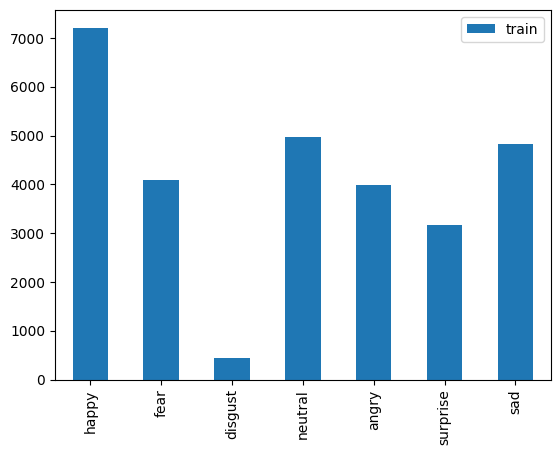

In [8]:
train_count.transpose().plot(kind='bar')

<Axes: >

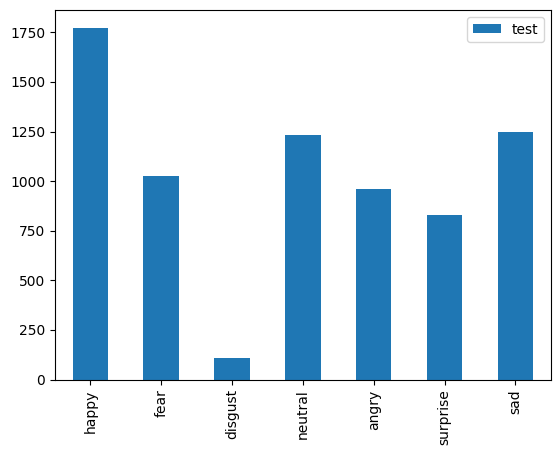

In [10]:
test_count.transpose().plot(kind='bar')

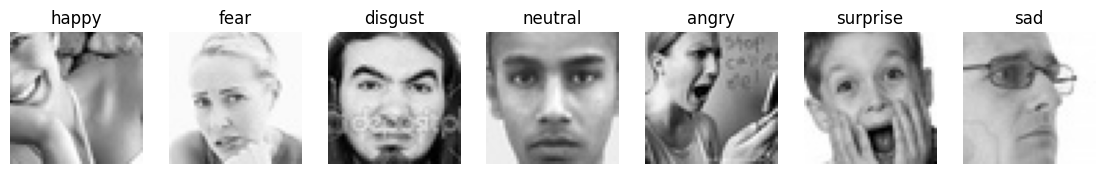

In [11]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[5]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Creating train test and validation datasets

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='training')
validation_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [13]:
# labels
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Model Architecture

In [14]:
weight_decay = 1e-4

num_classes = 7

model = tf.keras.models.Sequential()

model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(48,48,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation="linear"))
model.add(Activation('elu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0003), metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,315,335 (5.02 MB)

 Trainable params: 1,314,311 (5.01 MB)

 Non-trainable params: 1,024 (4.00 KB)

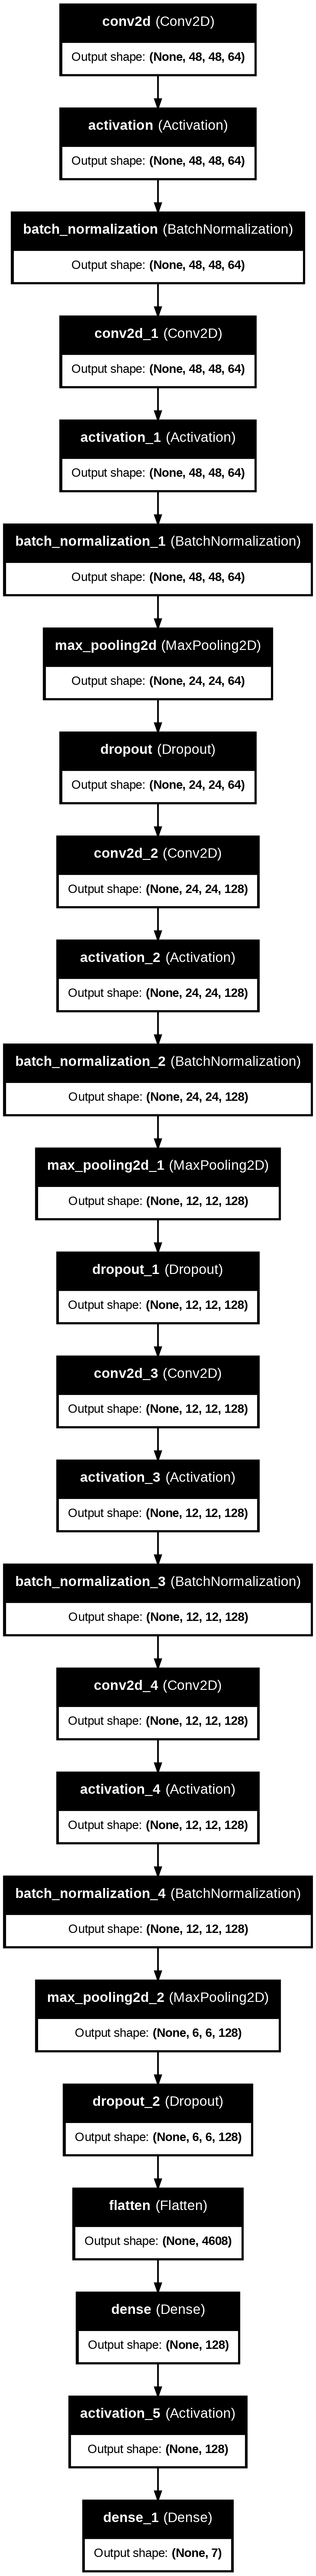

In [15]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [21]:
checkpointer = [
    EarlyStopping(
        monitor='val_accuracy',
        verbose=1,
        restore_best_weights=True,
        mode="max",
        patience=10
    ),
    ModelCheckpoint(
        filepath='model.weights.best.keras',  # Corrected filepath
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        mode="max"
    )
]


## Model Training

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

history = model.fit(x=training_set,
                 validation_data=validation_set,
                 epochs=200,
                 callbacks=[checkpointer],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2612 - loss: 2.1662
Epoch 1: val_accuracy improved from -inf to 0.32145, saving model to model.weights.best.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 1551s 4s/step - accuracy: 0.2613 - loss: 2.1653 - val_accuracy: 0.3215 - val_loss: 1.9183
Epoch 2/200
  1/358 ━━━━━━━━━━━━━━━━━━━━ 28:23 5s/step - accuracy: 0.4531 - loss: 1.5004

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.32145
358/358 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4531 - loss: 0.7523 - val_accuracy: 0.2889 - val_loss: 1.1190
Epoch 3/200
 50/358 ━━━━━━━━━━━━━━━━━━━━ 20:39 4s/step - accuracy: 0.3717 - loss: 1.6397

## Model Performance

In [ ]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)
plt.show()

In [ ]:
# saving the model
model.save("fer_model.h5")

## Test Accuracy

In [ ]:
print(f"Test accuracy = {model.evaluate(test_set ,batch_size=test_set.batch_size,steps=test_set.n // test_set.batch_size)[1]*100}%")

## Confusion Matrix

### Confusion matrix on Training Set

In [ ]:
y_pred = model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

### Confusion Matrix on Validation Dataset

In [ ]:
y_pred = model.predict(validation_set)
y_pred = np.argmax(y_pred, axis=1)
cm_val = confusion_matrix(validation_set.classes, y_pred)
print('Confusion Matrix')
print(cm_val)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

## Confusion Matrix on Test Dataset

In [ ]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

## Plotting Predictions

In [ ]:
# next function assigns one batch to variables, i.e x_test,y_test will have 64 images
x_test,y_test = next(test_set)
predict = model.predict(x_test)

In [ ]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = class_labels[(np.argmax(predict[index]))]
    true_index = class_labels[(np.argmax(y_test[index]))]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))